In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# Data preprocessing

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (100, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 2000 files belonging to 2 classes.


In [3]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 1000 files belonging to 2 classes.


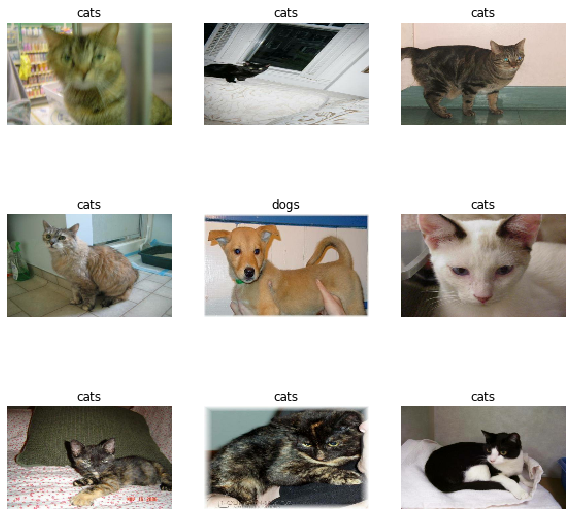

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [5]:
val_batches = tf.data.experimental.cardinality(validation_set)
test_dataset = validation_set.take(val_batches // 5)
validation_dataset = validation_set.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [7]:
AUTOTUNE =  tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

Show the augmented data

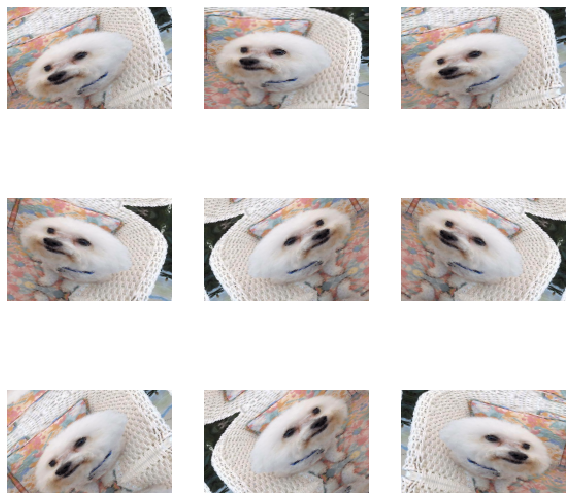

In [9]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [10]:
preprocessing_input = tf.keras.applications.mobilenet_v3.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


In [10]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

4349952/4334752 [==============================] - 1s 0us/step


In [ ]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    image_batch, label_batch = next(iter(train_dataset))
    feature_batch = base_model(image_batch)
    print(feature_batch.shape)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [14]:
image_batch

<tf.Tensor: shape=(32, 100, 160, 3), dtype=float32, numpy=
array([[[[166.79375  , 140.79375  , 106.617966 ],
         [162.70744  , 135.70744  , 105.707436 ],
         [207.17383  , 180.17383  , 151.76758  ],
         ...,
         [143.28906  , 124.17969  ,  97.47656  ],
         [141.16095  , 115.07536  ,  88.186676 ],
         [105.81677  ,  86.925804 ,  52.184357 ]],

        [[184.01993  , 157.01993  , 128.26993  ],
         [178.86096  , 151.83868  , 123.4672   ],
         [207.08203  , 179.69727  , 153.85156  ],
         ...,
         [168.25781  , 143.60156  , 113.42969  ],
         [155.03232  , 123.724106 ,  95.70184  ],
         [139.56389  , 114.18776  ,  84.622116 ]],

        [[189.7504   , 161.7504   , 139.56718  ],
         [192.9793   , 164.9793   , 142.9793   ],
         [182.23438  , 154.23438  , 132.16016  ],
         ...,
         [165.9668   , 139.22656  , 111.97656  ],
         [132.89908  ,  98.352905 ,  75.54634  ],
         [135.68045  , 107.14221  ,  85.30431

In [ ]:
feature_batch = base_model(image_batch[0:1])
print(feature_batch.shape)
base_model.trainable = False